In [ ]:
from langchain.llms import Ollama
import re, json, time
from datetime import datetime
from sentiment_predict.sentiment_tools_variables import CRYPTO_MAP
from sentiment_predict.predict_sentiment_tools import get_targets_posts, get_sentiment_score_seq
from market_data_predict.market_predict_tools import crypto_price_prediction

# Set up the Ollama LLM
llm = Ollama(model="deepseek-r1:8b")
llm2 = Ollama(model="llama3.1:8b")

def generate_analysis_prompt(data):
    string = (f"Please use the following information provide user a comprehensive suggestion on investment portfolio. "
              f"Data: {data}"
              f"The normal sentiment score is 0.6. "
              f"Assess the potential risks and benefits of investing in {', '.join(data.keys())} based on these metrics.\n"
              f"Provide an optimal combination of investments in the listed cryptocurrencies and suggest what percentage of assets should be allocated to each.\n"
              f"Offer actionable recommendations—buy, hold, or sell—with reasoning that considers market conditions, sentiment trends, and price predictions.")
    return string

def extract_info_prompt(user_input):
    prompt = (f"Extract a list of cryptocurrency symbols and the datetime from the following user input. "
              f"If no datetime is provided, return 'now'. "
              f"If no crypto symbols are found, return an empty list. "
              f"Respond ONLY in JSON format with keys: crypto_symbols (list of strings) and datetime (string in format YYYY-MM-DD HH:MM:SS). "
              f"\n\nUser Input:\n{user_input}\n\n"
              f"Your Response (strictly JSON format, no explanation)\nExample Output: \n"
              "```json{'crypto_symbols': [], 'datetime': 'now'}```\nor\n"
              "```json{'crypto_symbols': ['BTC', 'ETC'], 'datetime': '2025-01-30 14:25:00'}```")
    return prompt

def parse_dict_from_string(text):
    match = re.search(r"```json\n({.*?})\n```", text, re.DOTALL)

    if match:
        json_str = match.group(1)  # Extract the JSON string
        output_dict = json.loads(json_str)  # Convert to dictionary
        return output_dict
    else:
        raise TypeError("No JSON found")

def extract_info(user_input):
    prompt = extract_info_prompt(user_input)
    response = llm2.invoke(prompt)
    try:
        result = parse_dict_from_string(response)
    except TypeError:
        raise TypeError("Internal Error: Parse Json Data...")

    if len(result['crypto_symbols']) == 0:
        raise ValueError("Please State What crypto you want to analyze...")
    else:
        not_in_list2 = [item for item in result['crypto_symbols'] if item not in list(CRYPTO_MAP.keys())]
        if len(not_in_list2) > 0:
            raise ValueError(f"{not_in_list2} data is currently not available, Please change.")
        else:
            crypto_symbols = result['crypto_symbols']
            current_time = result['datetime']
            if current_time == "now":
                current_time = int(time.time())
            else:
                current_time = datetime.utcfromtimestamp(int(current_time)).strftime('%Y-%m-%d %H:%M:%S')
            return crypto_symbols, current_time


def reformat_data(data):
    reformatted = {}
    for i in range(len(data['type'])):
        entry_type = data['type'][i]
        reformatted[entry_type] = {
            'datetime': data['datetime'][i],
            'The price of the asset at the given timestamp': data['close'][i],
            'The percentage change in price in a day before datetime': data['change'][i],
            'The number of units traded during the period': data['volume'][i]
        }
    return reformatted


def portfolio_suggest_agent(text, sentiment_seq_num=5):
    # extract info from user input
    try:
        crypto_symbols, current_time = extract_info(text)
    except ValueError as e:
        return str(e)

    result = {}

    for crypto in crypto_symbols:
        # Predict Current Sentiments
        posts = get_targets_posts(crypto) # get the lastest 35 days news
        sentiment_seq = get_sentiment_score_seq(posts, current_time=current_time, seq_num=sentiment_seq_num)
        
        result[crypto] = {
            "Crypto Symbol": crypto,
            f"Market Sentiments in past {7*sentiment_seq_num} days": sentiment_seq,
        }

        # model 1 predict & feature engineering
        model_output = crypto_price_prediction(crypto)
        data = reformat_data(model_output)

        # save data
        result[crypto].update(data)

    # LLM analyze
    prompt = generate_analysis_prompt(result)
    return llm.invoke(prompt)

2025-01-30 21:55:28 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-01-30 21:55:28 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


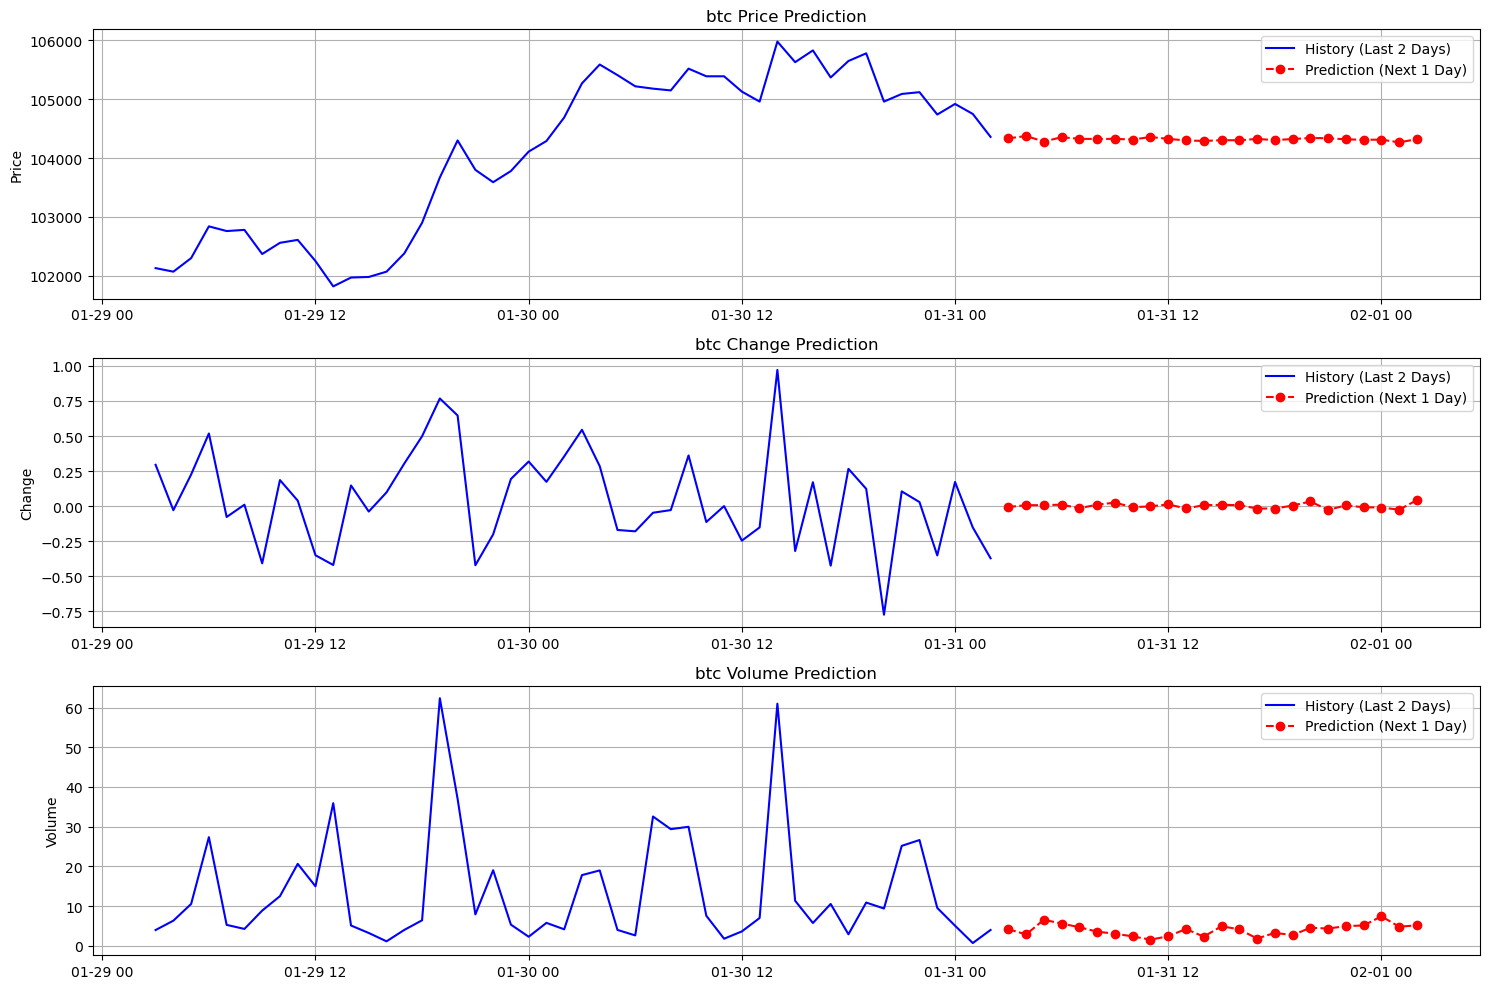

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


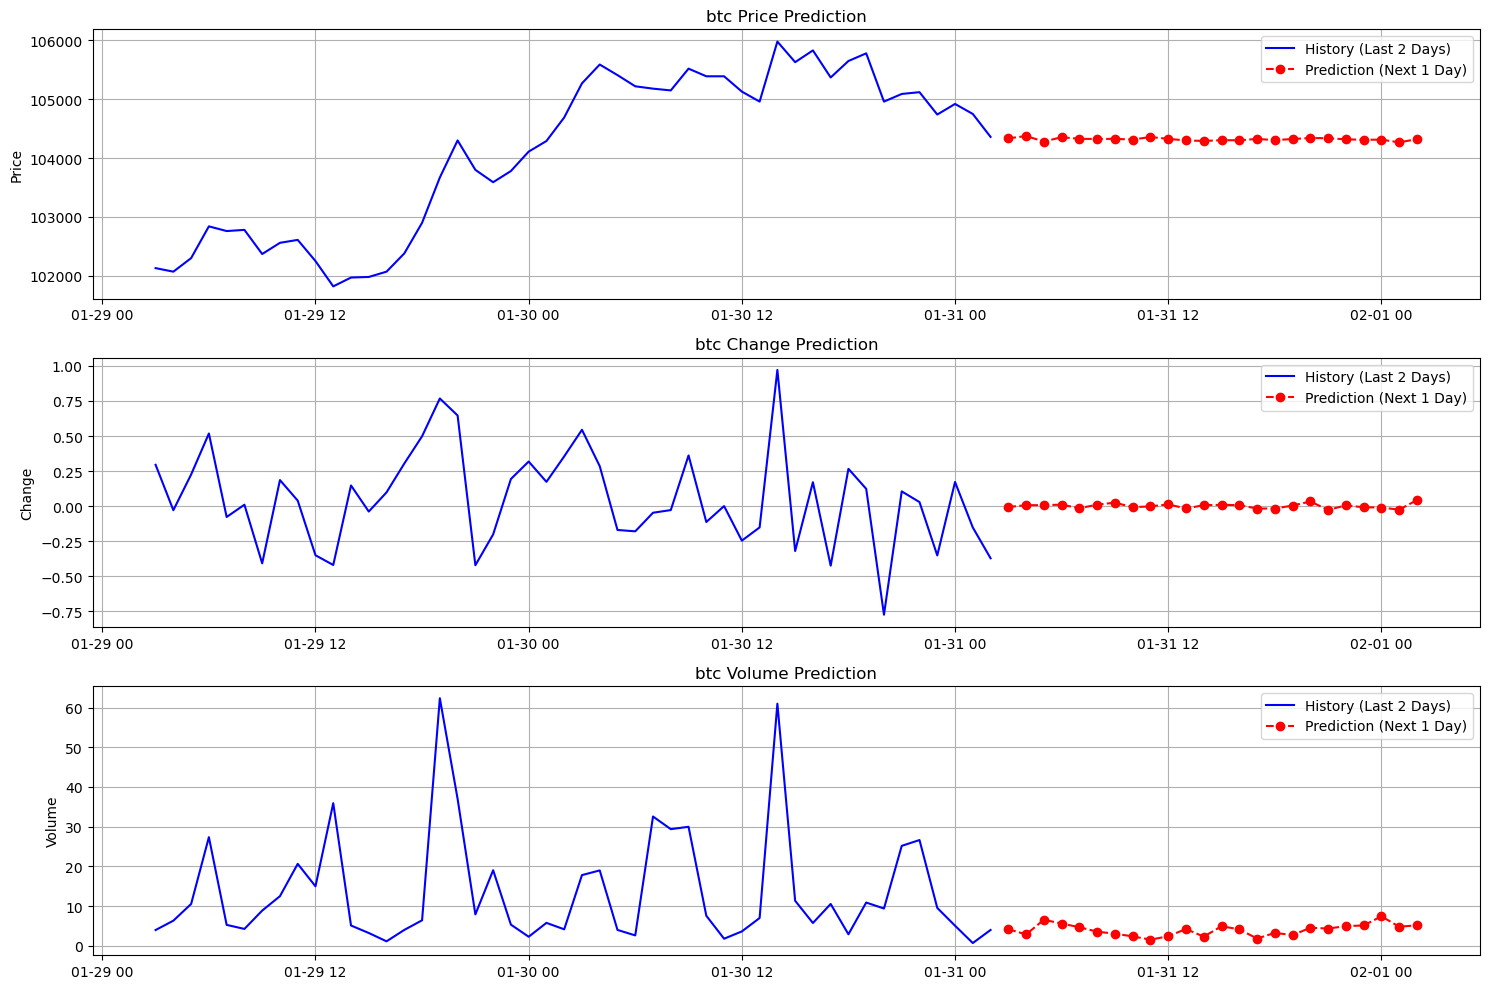

In [3]:
text = portfolio_suggest_agent("Any suggestion on investment to BTC and ETC?")

In [4]:
print(text)

<think>
Alright, so I need to figure out a comprehensive investment portfolio suggestion using Bitcoin (BTC) and Ethereum Classic (ETC). The user has provided some data on both assets over the past 35 days, including market sentiments, historical and predicted prices, and trading volumes. They also mentioned that the normal sentiment score is 0.6.

First, I'll start by analyzing each cryptocurrency individually. Let's look at BTC first. From the data, the market sentiments in the past 35 days are [0.46943652945349473, 0.9581734688545499, 0.6945952386964628, 0.8623700792225342, 0.626458036865752]. The average of these is (I'll calculate that later), but looking at the trend, the sentiments start a bit low, then spike to around 0.95, which is pretty high, followed by a dip and then a slight rise again. 

The history shows that on January 31st, the price was 104360.0 with a negative daily change of about -3.73%, and only 3.976 units traded. Then, the prediction for February 1st suggests a